# Loading packages and time series data

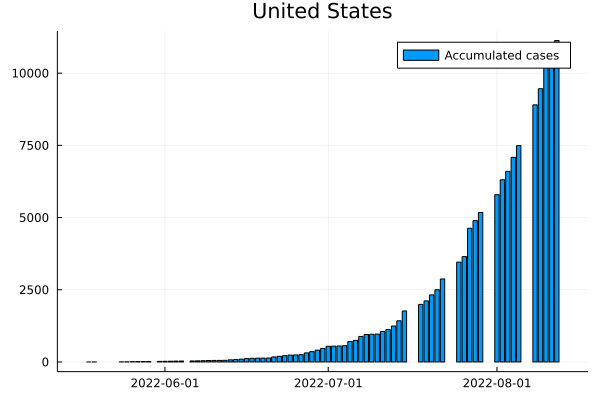

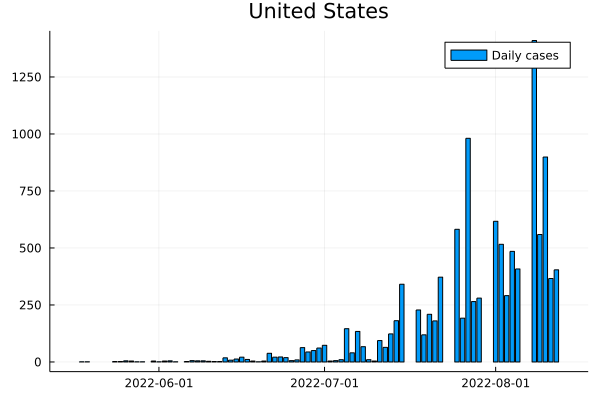

In [54]:
using Monkeypox
using Optim
using Optimization
using Plots
using Turing
using StatsPlots
using BSON:@save,@load
url = "./data/timeseries-country-confirmed.csv"
url1 = "https://raw.githubusercontent.com/globaldothealth/monkeypox/main/timeseries-country-confirmed.csv"
country = "United States"
data_on, acc, cases, datatspan, datadate = datasource!(url, country)
display(bar(datadate,acc[datatspan],label="Accumulated cases",title = country))
savefig("./output/accdata.png")
display(bar(datadate, cases[datatspan], label="Daily cases", title=country))
savefig("./output/dailydata.png")

# Best fit

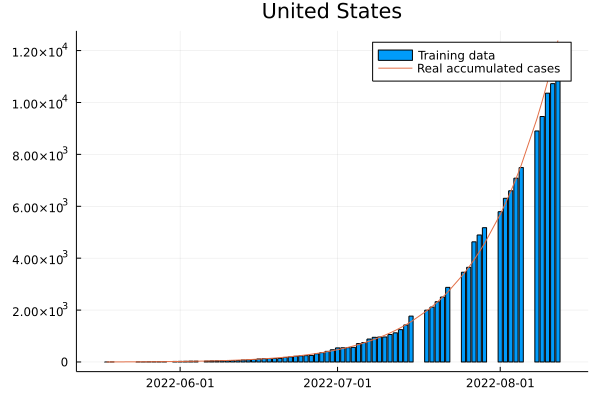

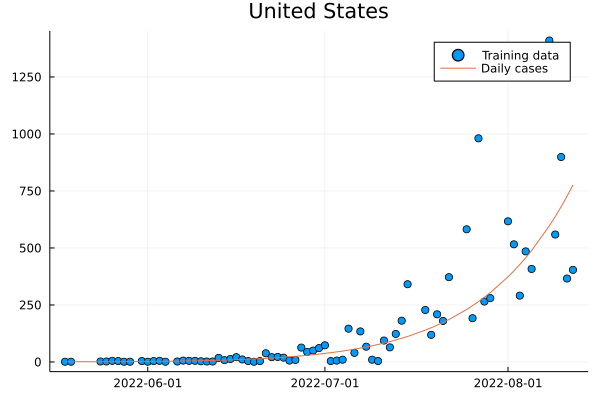

In [59]:
N = 329500000.0
#N = 329500000.0 # population
p_test = [0.18719443266063507,
    0.8499808507112641,
    0.03288289808557796,
    0.22554350810234938,
    0.9999920454874591,
    0.00016967399445203297]# ρ,σ,h,α
pknown = [0.0, 0.0, 1 / 30, 1.0] # B,μ,δ,ϕ
prob_pred = controlmonkeypoxprob!(N, p_test, acc, pknown)
prediction = controlsimulate!(prob_pred, N, p_test, datatspan, pknown)
bar(datadate, acc[datatspan], label="Training data")
display(plot!(datadate, prediction[10, :], label="Real accumulated cases",title = country))
savefig("./output/acc.png")
#plot(datadate, prediction[2, :])
#display(plot(chainout[1]))
datatspan1 = 0:length(acc)-1
prediction1 = controlsimulate!(prob_pred, N, p_test, datatspan1, pknown)
mid = zeros(length(acc))
mid[2:end] = prediction1[10, 1:end-1]
pred_daily = prediction1[10, :] - mid
scatter(datadate, cases[datatspan], label="Training data")
display(plot!(datadate,pred_daily[datatspan], label="Daily cases",title = country))
savefig("./output/daily.png")


# Inference for model with control measures

In [60]:
N = 329500000.0
#N = 329500000.0 # population
θ = [0.3, 0.3, 0.2, 0.1, 0.7, 0.01]# ρ,σ,h,α
pknown = [0.0, 0.0, 1 / 30, 1.0] # B,μ,δ,ϕ
lb = [0.0001, 0.0001, 0, 0.0001, 0.0001, 0.0]
ub = [1.0, 1.0, 1.0, 1.0, 1.0, 0.1]
alg = Optim.NelderMead()
p_min = controlmonkeypoxopt!(N, θ, acc, cases, datatspan, pknown, lb, ub, alg)
chainout = controlmonkeypoxinference!(N, p_min, acc, cases, datatspan, pknown, lb, ub)


Sampling (3 threads)   0%|█                             |  ETA: N/A
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\AdvancedHMC\

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 1.52587890625e-6
└ @ Turing.Inference F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\Turing\S4Y4B\src\inference\hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 9.5367431640625e-8
└ @ Turing.Inference F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\Turing\S4Y4B\src\inference\hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 6.103515625e-6
└ @ Turing.Inference F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\Turing\S4Y4B\src\inference\hmc.jl:188
┌ Warning: The current propo

(MCMC chain (1000×19×3 Array{Float64, 3}), [0.008695269779136098, 0.9950995277608576, 0.015648913317389213, 0.20300320641486008, 0.8000380188838914, 0.09999382708995999])

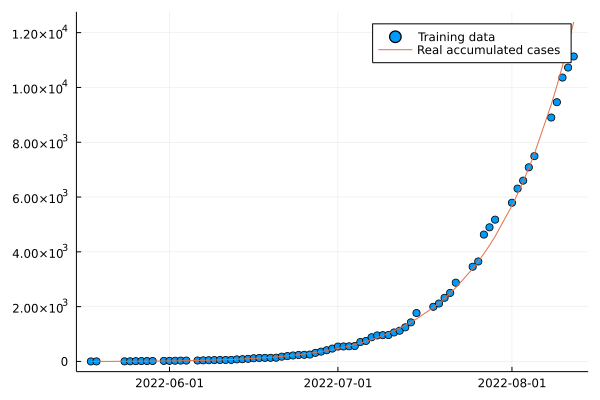

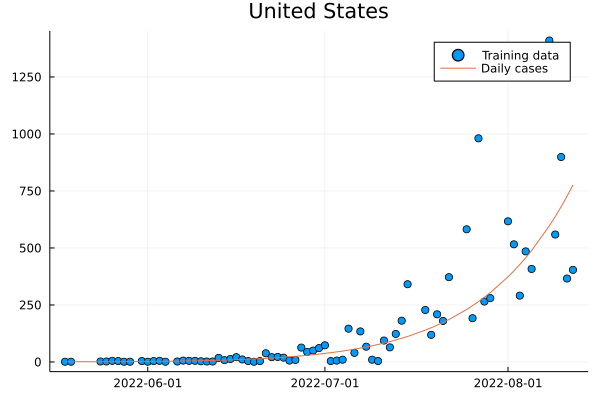

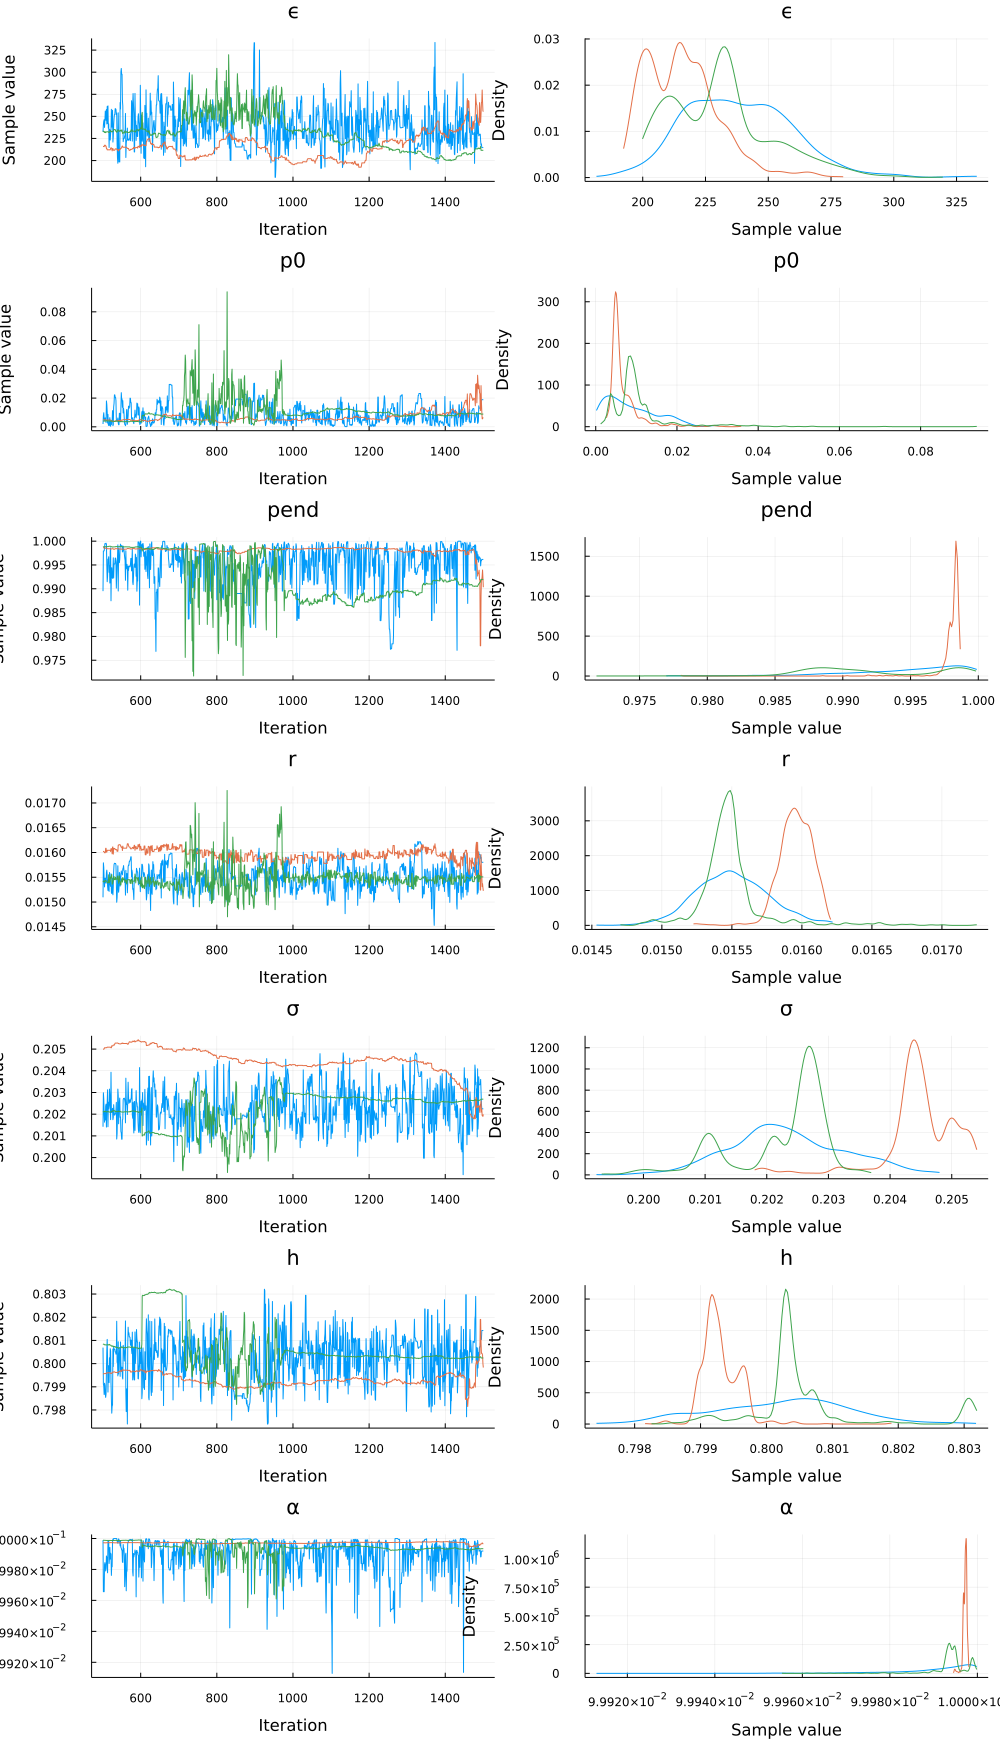

data parameter:[0.008695269779136098, 0.9950995277608576, 0.015648913317389213, 0.20300320641486008, 0.8000380188838914, 0.09999382708995999]


In [63]:
println("data parameter:", chainout[2])
prob_pred = controlmonkeypoxprob!(N, θ, acc, pknown)
prediction = controlsimulate!(prob_pred, N, p_min, datatspan, pknown)
scatter(datadate, acc[datatspan], label="Training data")
display(plot!(datadate, prediction[10, :], label="Real accumulated cases"))
savefig("./output/controlacc.png")
#plot(datadate, prediction[2, :])
#display(plot(chainout[1]))
datatspan1 = 0:length(acc)-1
prediction1 = controlsimulate!(prob_pred, N, p_min, datatspan1, pknown)
mid = zeros(length(acc))
mid[2:end] = prediction1[10, 1:end-1]
pred_daily = prediction1[10, :] - mid
scatter(datadate, cases[datatspan], label="Training data")
display(plot!(datadate, pred_daily[datatspan], label="Daily cases", title=country))
savefig("./output/controldaily.png")
#plot(datadate, prediction[2, :])
display(plot(chainout[1]))
savefig("./output/controlchain.png")

# Inference for Models without control measures

In [ ]:
using Monkeypox
using Optim
using Optimization
using Plots
using Turing
using StatsPlots
url = "./data/timeseries-country-confirmed.csv"
#url1 = "https://raw.githubusercontent.com/globaldothealth/monkeypox/main/timeseries-country-confirmed.csv"
country = "United States"
data_on, acc, cases, datatspan, datadate = datasource!(url, country)
##
## without control
#N = 38010000.0
N = 329500000.0 # population
θ = [0.3, 0.3, 0.7, 0.01]# ρ,σ,h,α
pknown = [0.0, 0.0, 1 / 30, 1.0] # B,μ,δ,ϕ
lb = [0.0001, 0.0001, 0.0001, 0.0]
ub = [1.0, 1.0, 1.0, 0.1]
alg = Optim.NelderMead()
p_min = monkeypoxopt!(N, θ, acc, cases, datatspan, pknown, lb, ub, alg)

chainout = monkeypoxinference!(N, p_min, acc, cases, datatspan, pknown, lb, ub)


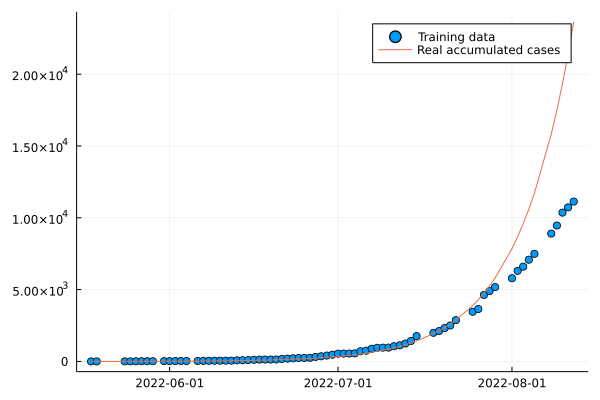

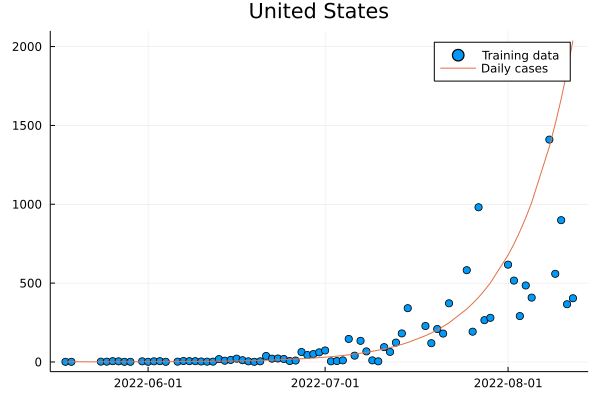

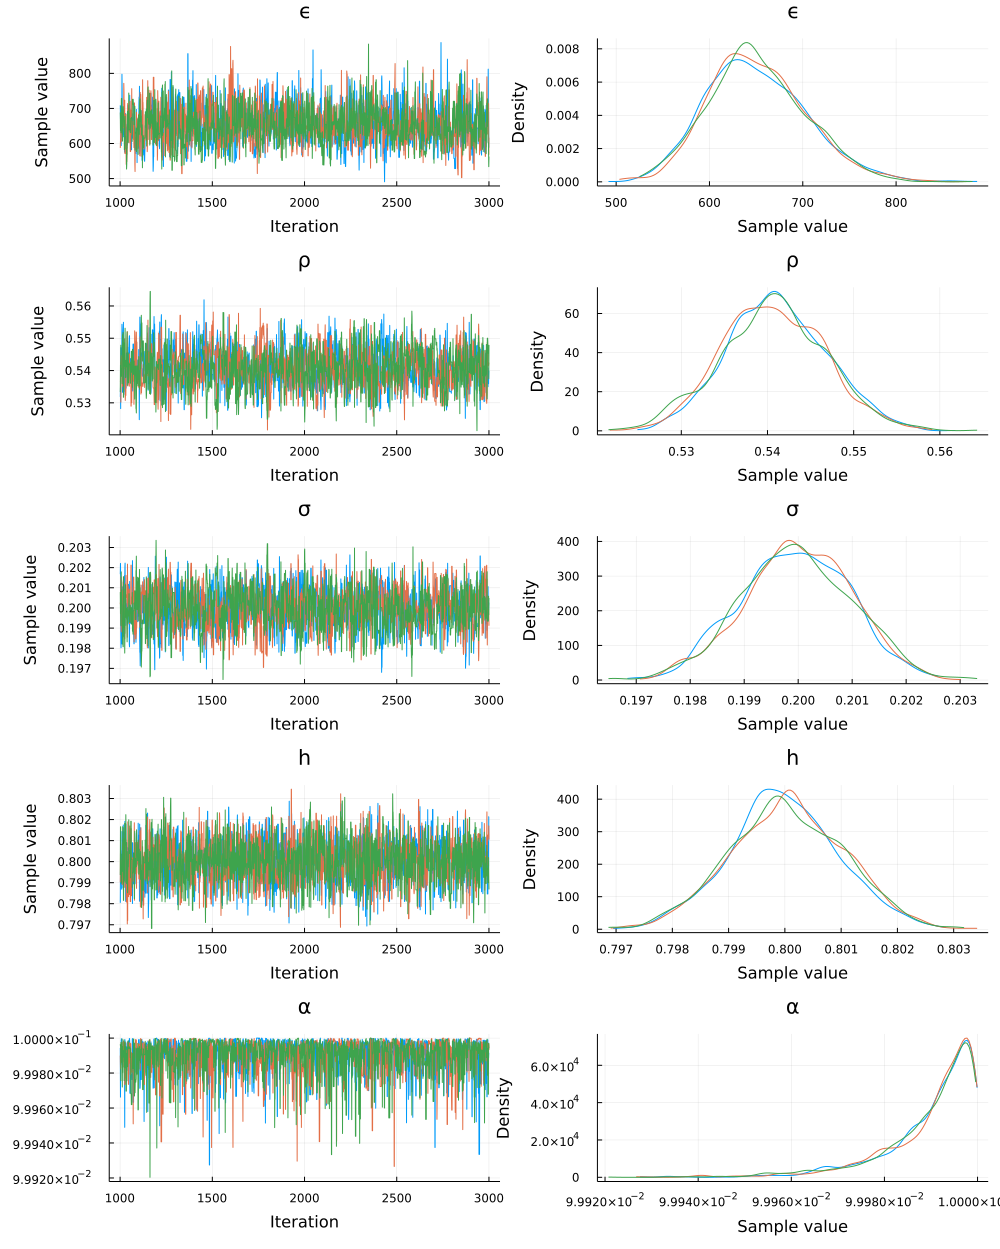

data parameter:[0.5408408551844572, 0.19997279839683263, 0.8000240530034041, 0.09999001588394262]


In [65]:
println("data parameter:", chainout[2])
prob_pred = monkeypoxprob!(N, θ, acc, pknown)
prediction = simulate!(prob_pred, N, p_min, datatspan, pknown)
scatter(datadate, acc[datatspan], label="Training data")
display(plot!(datadate, prediction[10, :], label="Real accumulated cases"))
savefig("./output/nocontrolacc.png")
datatspan1 = 0:length(acc)-1
prediction1 = simulate!(prob_pred, N, p_min, datatspan1, pknown)
mid = zeros(length(acc))
mid[2:end] = prediction1[10, 1:end-1]
pred_daily = prediction1[10, :] - mid
scatter(datadate, cases[datatspan], label="Training data")
display(plot!(datadate, pred_daily[datatspan], label="Daily cases", title=country))
savefig("./output/nocontroldaily.png")
display(plot(chainout[1]))
savefig("./output/nocontrolfitchain.png")